Mojtaba Aprouz - 40030594

Final project of machine learning

Face recognition




Method:

Preprocesses by 'Histogram equalizetion' then 'Edge detection'

Feature extraction by 'PCA'

Classification by 'SVM ( RBF )'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unrar dataset
!unrar x /content/drive/MyDrive/Colab_Notebooks/Face_Recognition_Dataset.rar

In [4]:
#spliting folders of dataset to train and test
!pip install split-folders
import splitfolders
splitfolders.ratio("/content/Face_Recognition_Dataset/CroppedYale",output="dataset",seed=1337,ratio=(0.8,0,0.2), group_prefix=None, move=False)


Copying files: 2547 files [00:00, 4491.36 files/s]


In [151]:
import os
import numpy as np
import cv2
import pandas as pd
from  matplotlib import pyplot as plt
from skimage import io
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [152]:
#function of loading dataset 
#preprocesses : histogram equalizetion then edge detection
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]

    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
          if file[-4:]=='.pgm' or file[-4:]=='.bad':       
            image_path= os.path.join(img_folder, dir1,  file)
            #load image
            image= cv2.imread( image_path,-1) 
            image=np.array(image)
            #resize diffrente images
            if (np.shape(image)[0]*np.shape(image)[1])!=(192*168):
              image=cv2.resize(image, (192, 168),interpolation = cv2.INTER_AREA)
            #histogram equalizetion
            image = cv2.equalizeHist(image)
            #extract edges of image
            edges = cv2.Canny(image=image, threshold1=100, threshold2=200)
            #reshape image to 1_dim array 
            edges=np.reshape(edges,np.shape(edges)[0]*np.shape(edges)[1])
            img_data_array.append(edges)
            class_name.append(dir1)
    return img_data_array, class_name

In [153]:
#loading train and test data
X_train, Y_train =create_dataset(r'/content/dataset/train/');
X_train=np.array(X_train)
X_test, Y_test_class =create_dataset(r'/content/dataset/test/')
X_test=np.array(X_test)

In [154]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

scores=[]
estimators=[]
best_score=0
n_com=0
for n_components in range(50,100,5):
  #principal components 
  pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
  X_train_pca = pca.transform(X_train)
  test_pc = pca.transform(X_test)
  #Finding suit parametrs of SVM
  param_grid = {
      "C": loguniform(1e3, 1e5),
      "gamma": loguniform(1e-4, 1e-1),
  }
  clf = RandomizedSearchCV(
      SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=20
  )
  #fitting on prin principal components
  clf = clf.fit(X_train_pca, Y_train)
  #Best estimator found by grid search
  estimator=clf.best_estimator_
  estimators.append(estimator)

  #score
  score=clf.score(test_pc , Y_test_class)
  scores.append(score)
  #best result
  if score>best_score:
    best_score=score
    best_estimator=estimator
    n_com=n_components

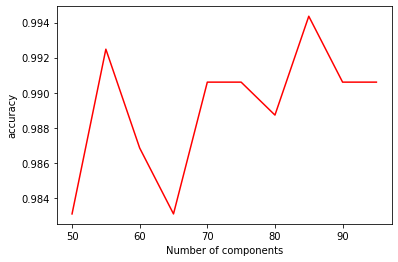

In [164]:
#plotting result of differente number of principal components
plt.plot(range(50,100,5),scores, 'r', )
plt.xlabel("Number of components")
plt.ylabel("accuracy")
plt.show()

In [157]:
# best result
n_components = n_com
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
X_train_pca = pca.transform(X_train)
test_pca = pca.transform(X_test)
svm = SVC(kernel='rbf' , class_weight='balanced' , C=best_estimator.C , gamma=best_estimator.gamma)
svm.fit(X_train_pca , Y_train)
print("best result on",best_estimator )
print("best features:",n_components )
print("score :",svm.score(test_pca , Y_test_class))

best result on SVC(C=10051.137949154709, class_weight='balanced', gamma=0.010558368154723188)
best features: 85
score : 0.9962406015037594


In [158]:
#precision    recall  f1-score   support
print("Predicting the people names on the testing set")
y_pred = svm.predict(test_pca)
print(classification_report(Y_test_class, y_pred))

Predicting the people names on the testing set
              precision    recall  f1-score   support

     yaleB01       1.00      0.93      0.96        14
     yaleB02       1.00      1.00      1.00        14
     yaleB03       1.00      1.00      1.00        14
     yaleB04       1.00      1.00      1.00        14
     yaleB05       1.00      1.00      1.00        14
     yaleB06       1.00      1.00      1.00        14
     yaleB07       1.00      1.00      1.00        14
     yaleB08       1.00      1.00      1.00        14
     yaleB09       1.00      1.00      1.00        14
     yaleB10       1.00      1.00      1.00        14
     yaleB11       0.93      1.00      0.97        14
     yaleB12       1.00      1.00      1.00        14
     yaleB13       1.00      1.00      1.00        14
     yaleB15       1.00      1.00      1.00        14
     yaleB16       1.00      1.00      1.00        14
     yaleB17       1.00      1.00      1.00        14
     yaleB18       1.00      1.00 

In [159]:
lst=(list(set(Y_test_class)))
lst.sort()
print(confusion_matrix(Y_test_class, y_pred,labels=lst))


[[13  0  0 ...  0  0  0]
 [ 0 14  0 ...  0  0  0]
 [ 0  0 14 ...  0  0  0]
 ...
 [ 0  0  0 ... 14  0  0]
 [ 0  0  0 ...  0 14  0]
 [ 0  0  0 ...  0  0 14]]


In [160]:
#confusion_matrix
import pandas as pd
df=pd.DataFrame(confusion_matrix(Y_test_class, y_pred,labels=lst),columns=lst,index=lst)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
print(df)

         yaleB01  yaleB02  yaleB03  yaleB04  yaleB05  yaleB06  yaleB07  \
yaleB01  13       0        0        0        0        0        0         
yaleB02  0        14       0        0        0        0        0         
yaleB03  0        0        14       0        0        0        0         
yaleB04  0        0        0        14       0        0        0         
yaleB05  0        0        0        0        14       0        0         
yaleB06  0        0        0        0        0        14       0         
yaleB07  0        0        0        0        0        0        14        
yaleB08  0        0        0        0        0        0        0         
yaleB09  0        0        0        0        0        0        0         
yaleB10  0        0        0        0        0        0        0         
yaleB11  0        0        0        0        0        0        0         
yaleB12  0        0        0        0        0        0        0         
yaleB13  0        0        0        0 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys
